# AIQDSC27 - Machine Learning Algorithms Project

**Student**: Quentin Le Roux

## Instructions

#### <span style="color:red">Note on Data Leakage</span>

From [Kaggle](https://www.kaggle.com/alexisbcook/data-leakage):

> "Data leakage (or leakage) happens when **your training data contains information about the target**, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.
> 
> [...]
> 
> **Target leakage** occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.
> 
> [...] 
> 
> Validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called **train-test contamination**."

#### <span style="color:red">Note on the required models</span>

The mentioned models are:

- *Linear Regression*
- KNN
- Naive Bayes
- RandomForest
- SVM

Linear Regression is a **regression** model while the three others are **classification** models. Though we will implement linear regression in this project, we will also add **logistic regression** as a classification model to perform more classification comparisons.

Furthermore, we will also include further modifications of the linear regression model (i.e. Lasso, Ridge, ElasticSearch) in order to have some form of comparison with regards to regression.

## 0. Table of Content

1. **Introduction**

    a. Overview of project steps
    
    b. Library imports and built functions


2. **Pre-processing**

    a. Overview of pre-processing steps
    
    b. Data pre-processing
   
   
3. **Modeling**

    a. Regression
    
        a.1. Linear Regression
        
        a.2. Ridge
        
        a.3. Lasso
        
        a.4. ElasticSearch
        
        a.5. Observations
    
    b. Classification
    
        b.1. Logistic Regression
    
        b.2. KNN
    
        b.3. Naive Bayes
    
        b.4. Random Forest
        
        b.5. SVM
        
        b.6. Summarizing results
 
 
4. **Exploring our best model**

    a. Removing ETHNICITY from the dataset
    
    b. Performing PCA on our Bag of Words representation
    
    b. Binary classification
    
    c. Overall parameter impact overview


5. **Conclusion**

    a. Model Choice

    b. Best Model Parameters
    
    c. Looking for ways to improve the predictions
    
    d. Further explorations?

## 1. Introduction

### 1.1 Overview of project steps
    
The project will proceed using the following steps:

1. **Pre-processing of the dataset** (building a train and test set of features)

> We end up with a training and testing set containing 842 features (incl. 819 bag-of-words embedding of the DIAGNOSIS table)

2. **Training and testing our selected models**: Linear Regression, KNN, Naive Bayes, RandomForest, SVM


3. **Selecting the most promising** of the four and **perform further hyperparameter tuning, dataset refining, etc.** to increase the model's performance


4. **Concluding** and propose further areas of exploration


### 1.2 Library imports and built functions

In [1]:
# Library imports

import datetime as dt
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

from itertools import cycle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function Declarations

def remove_stop_words(tokenized_sentence):
    """
    Removes the stop words from a tokenized sentence
    """
    punctuation = [".", ",", "[", "]", "`", "(", ")", 
                   "?", "'", "'s", ":", "!"]
    stop_words = stopwords.words('english')
    stop_words += punctuation
    return [w for w in tokenized_sentence if w not in stop_words]
    
def lemmatize(tokenized_sentence):
    """
    Create a lemmatizer object and lematized tokenized items 
    (e.g. sentences). Might require running the following:
        nltk.download('wordnet')
    """
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in tokenized_sentence]

sentence_processing = lambda sentence: " ".join(
    lemmatize(
        remove_stop_words(
            word_tokenize(str.lower(str(sentence)))
        )
    )
)

def confusion(model, X, y, title):
    """
    Prints a confusion matrix of a classification model
    """
    disp = plot_confusion_matrix(model, 
                                 X, 
                                 y,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)
    
def regression_score(pred_train, pred_test, y_train, y_test):
    """
    Prints the MSE and R^2 of a regression model
    """
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    print("--- Train Set Scores ---")
    print('Mean squared error: %.2f' % mse_train)
    print('Coefficient of determination: %.2f'% r2_train)
    print("\n--- Test Set Scores ---")
    print('Mean squared error: %.2f' % mse_test)
    print('Coefficient of determination: %.2f'% r2_test)
    return mse_train, mse_test, r2_train, r2_test
    
def classification_score(pred_train, pred_test, y_train, y_test):
    """
    Prints the accuracy and F1 scores for train and test sets of a 
    classification model
    """
    f1_score_train = f1_score(pred_train, y_train, average='weighted')
    acc_score_train = accuracy_score(pred_train, y_train)
    f1_score_test = f1_score(pred_test, y_test, average='weighted')
    acc_score_test = accuracy_score(pred_test, y_test)
    print("--- Train Set Scores ---")
    print("Accuracy: %.2f" % acc_score_train)
    print("F1 score: %.2f" % f1_score_train)
    print("\n--- Test Set Scores ---")
    print("Accuracy: %.2f" % acc_score_test)
    print("F1 score: %.2f" % f1_score_test)
    return acc_score_train, acc_score_test, f1_score_train, f1_score_test

## 2. Pre-processing

### 2.1 Overview of pre-processing steps
    
1. Loading the training and testing sets


2. Providing preliminary notes on the training and testing sets


3. Identifying columns/features with a risk of data leakage

    - issues related to mismatching "entries for one patient" in the dataset
    
    - Data leakage about a potential target variable in some columns


4. Selecting the feature variables (X)

    - Discarding columns due to data leakage
    
    - Selecting model features
    

5. Building/Wrangling the features variables

    - Dealing with NaN values
    
    - Building a LENGTH_OF_STAY feature
    
    - Building an AGE feature
    
    - One-hot encoding the kept discrete features (GENDER, MARITAL_STATUS, ETHNICITY, INSURANCE, ADMISSION_TYPE)
    
    - Building a word embedding representation of the DIAGNOSIS column
    
    - Building the final training and testing datasets


6. Building the target variable(s) (Y)

    - Building a Regression target variable
    
    - Building a Classification target variable



### 2.2 Data Pre-processing

#### 2.2.1 - <u>Loading the *training* and *testing* sets:</u>

We load the dataset and also create placeholder variables. These will hold the processed training and testing data so that we do not erase the original data.

In [3]:
online_path = "http://www.i3s.unice.fr/~riveill/dataset/MIMIC-III-readmission/"
train_set_path = online_path + "train.csv.zip"
test_set_path = online_path + "test.csv.zip"

local_train_set_path = "./datasets/train.csv.zip"
local_test_set_path = "./datasets/test.csv.zip"

In [4]:
# df_train = pd.read_csv(train_set_path)
# df_train = pd.read_csv(test_set_path)

df_train = pd.read_csv(local_train_set_path)
df_test = pd.read_csv(local_test_set_path)

In [5]:
X_train = None
X_test = None

In [6]:
y_train_regression = None
y_test_regression = None
y_train_classification = None
y_test_classification = None

#### 2.2.2 - <u>Providing preliminary notes on the training and testing sets:</u>

- We find that the training dataset holds **2000 entries**, while the testing dataset holds **901 entries**, i.e., a **69 to 31 train-test ratio**. 

> A small dataset usually implies the following rule of thumb with regards to training: When a dataset is small a ratio of 80 to 20 train-test split is preferable. As such, the current split is okay as-is.


- There seems to be **several features with NaN values**. We will have to decide what to do with them.


- The available features are of types **int64** or **Object**. We will have to modify the types of those variables accordingly.


- As seen in the [MIMIC-III Clinical Database Demo 1.4](https://physionet.org/content/mimiciii-demo/1.4/ADMISSIONS.csv), the DIAGNOSIS variable corresponds to a string value containing a list of diagnoses separated by specific characters (e.g. ' **/** ', ' **;** ', ' **,** ', ' **-** ', etc.). 

> A bag of words representation of DIAGNOSIS is provided in the dataset. Given that we see more than 0 or 1 values (i.e. binary values), we can infer that the provided BoW approach may represent some kind of importance associated with each word (e.g. number of time the term appears).

**Given the lack of information on the way the BoW was created, we might want to create our own word embedding representation**.
    
<u>Preliminary information on the sets:</u>

In [7]:
df_train.describe()

,SUBJECT_ID,HADM_ID,DAYS_NEXT_ADMIT,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
count,2000.000000,2000.000000,1210.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000
mean,18155.690500,150103.483000,119.883433,0.482500,2.858000,0.036000,0.747500,1.389000,0.660500,0.438500,...,0.447500,0.430500,0.216000,0.255500,0.421000,0.008000,0.119000,0.972500,0.189000,0.5050
std,26240.378348,29205.036893,404.753993,0.735503,2.253969,0.196783,1.179593,1.329121,0.895902,0.809658,...,0.847114,0.739894,0.544511,0.704605,0.801299,0.151484,0.376709,1.199359,0.551753,0.5001
min,11.000000,100095.000000,-0.602083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
25%,1490.500000,124979.500000,5.383333,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000
50%,3103.500000,150743.500000,13.219792,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0000
75%,25072.750000,174570.750000,25.327951,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.0000
max,99562.000000,199955.000000,3867.977778,5.000000,13.000000,2.000000,9.000000,10.000000,4.000000,7.000000,...,9.000000,5.000000,5.000000,8.000000,7.000000,4.000000,5.000000,6.000000,6.000000,1.0000


In [8]:
df_test.describe()

,SUBJECT_ID,HADM_ID,DAYS_NEXT_ADMIT,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
count,901.000000,901.000000,526.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,...,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000,901.000000
mean,18306.197558,149172.830189,84.578517,0.466149,2.817980,0.044395,0.728080,1.372919,0.700333,0.468368,...,0.468368,0.436182,0.201998,0.243063,0.440622,0.015538,0.119867,0.931188,0.241953,0.503885
std,26349.689656,29115.501914,304.437951,0.691390,2.256878,0.231479,1.165418,1.406611,0.944628,0.804397,...,0.919147,0.752463,0.538760,0.682942,0.784625,0.253383,0.354423,1.184030,0.624726,0.500263
min,6.000000,100039.000000,-0.454167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1521.000000,123423.000000,5.100868,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3176.000000,147718.000000,11.302431,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,25256.000000,174749.000000,22.211632,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,1.000000
max,99982.000000,199807.000000,3543.101389,4.000000,12.000000,2.000000,7.000000,7.000000,5.000000,7.000000,...,6.000000,5.000000,5.000000,5.000000,4.000000,5.000000,3.000000,7.000000,6.000000,1.000000


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SUBJECT_ID          2000 non-null   int64  
 1   HADM_ID             2000 non-null   int64  
 2   ADMITTIME           2000 non-null   object 
 3   DISCHTIME           2000 non-null   object 
 4   DAYS_NEXT_ADMIT     1210 non-null   float64
 5   NEXT_ADMITTIME      1210 non-null   object 
 6   ADMISSION_TYPE      2000 non-null   object 
 7   DEATHTIME           158 non-null    object 
 8   DISCHARGE_LOCATION  2000 non-null   object 
 9   INSURANCE           2000 non-null   object 
 10  MARITAL_STATUS      1924 non-null   object 
 11  ETHNICITY           2000 non-null   object 
 12  DIAGNOSIS           1998 non-null   object 
 13  TEXT                1925 non-null   object 
 14  GENDER              2000 non-null   object 
 15  DOB                 2000 non-null   object 
 16  blood 

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 901 entries, 0 to 900
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SUBJECT_ID          901 non-null    int64  
 1   HADM_ID             901 non-null    int64  
 2   ADMITTIME           901 non-null    object 
 3   DISCHTIME           901 non-null    object 
 4   DAYS_NEXT_ADMIT     526 non-null    float64
 5   NEXT_ADMITTIME      526 non-null    object 
 6   ADMISSION_TYPE      901 non-null    object 
 7   DEATHTIME           58 non-null     object 
 8   DISCHARGE_LOCATION  901 non-null    object 
 9   INSURANCE           901 non-null    object 
 10  MARITAL_STATUS      861 non-null    object 
 11  ETHNICITY           901 non-null    object 
 12  DIAGNOSIS           901 non-null    object 
 13  TEXT                871 non-null    object 
 14  GENDER              901 non-null    object 
 15  DOB                 901 non-null    object 
 16  blood   

#### 2.2.3 - <u>Identifying columns/features with a risk of data leakage:</u>

> <span style="color:red">The following examples are interesting as they outline data leakage risk we want to contain or remove</span>.
>  
> Our goal is also individualizing each row so that we reduce the dependencies between each of them. Each datapoint should be independent between each other.

1. <u>issues related to mismatching "entries for one patient" in the dataset</u>

It is possible that a single patient (i.e. a single SUBJECT_ID) has multiple entries in the dataset.

> Based on the [information provided by the repository for the MIMIC dataset](https://mimic.physionet.org/mimictables/admissions/), HADM_ID represents a single patient’s admission(s) to the hospital and SUBJECT_ID represents a single patient.
>
> To avoid data leakage, we must identify features which we will need to exclude due to leakage.

<u>Example with SUBJECT_ID 17:</u>

In [11]:
# We look for the number of times a single patient has been admitted 
# to a hospital. 
# We find that a single patient may have been admitted up to 15 times 
# in the training set.

df_train.pivot_table(index = ['SUBJECT_ID'], aggfunc ='size').unique()

array([ 1,  2, 15,  3,  5,  4,  6,  8])

In [12]:
# We identify that patient 17 has been admitted twice.

print(df_train.pivot_table(index = ['SUBJECT_ID'], aggfunc ='size').head(2))
df_train[df_train["SUBJECT_ID"]==17]

SUBJECT_ID
11    1
17    2
dtype: int64


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
1182,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaN,NaN,EMERGENCY,NaN,HOME HEALTH CARE,Private,...,1,1,2,0,0,0,0,1,0,0
1710,17,194023,2134-12-27 07:15:00,2134-12-31 16:05:00,128.920833,2135-05-09 14:11:00,ELECTIVE,NaN,HOME HEALTH CARE,Private,...,0,0,0,0,0,0,0,0,0,0


We want to check if patients have a number of rows equal to the number of admission mentioned in the data (i.e. 1 row = 1 admission). Based on the following data wrangling, it appears that:

- Some patients have a mismatched between the number of mentioned readmission dates and the number of lines associated to their case.

<u>Interpretation:</u> <span style="color:red">The dataset cannot be understood as a time series</span>. As such, each row (and their potential readmission) should be construed as independent from other rows. 

<u>Implication:</u> In terms of data leakage, it implies we should individualize each row in a way that no two rows can be linked to each other (independence).

<u>Example with SUBJECT_ID 937:</u>

In [13]:
# We find that patient 937 has been admitted twice but has only one 
# single record in the training dataset.

df_train[df_train["SUBJECT_ID"]==937]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
0,937,148592,2163-01-20 18:39:00,2163-01-24 08:00:00,0.061806,2163-01-24 09:29:00,EMERGENCY,2163-01-26 08:00:00,DEAD/EXPIRED,Medicare,...,0,0,0,0,1,0,0,0,0,1


<u>Example with SUBJECT_ID 808:</u>

In [14]:
# We see that patient 808 has three referenced admissions but the last
# record mentions another admission that is not referenced in the set.

# The admit times are also mismatched. There are 3 admissions with 
# each showing a next admission time, implying at least one admission 
# is missing from the dataset.

df_train[df_train["SUBJECT_ID"]==808]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,DISCHARGE_LOCATION,INSURANCE,...,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,OUTPUT_LABEL
553,808,197130,2181-11-16 08:18:00,2181-11-23 09:04:00,8.701389,2181-12-02 01:54:00,EMERGENCY,NaN,HOME HEALTH CARE,Private,...,0,0,0,2,0,0,0,3,0,1
1189,808,100677,2181-07-12 20:11:00,2181-07-17 13:14:00,13.395833,2181-07-30 22:44:00,EMERGENCY,NaN,HOME HEALTH CARE,Private,...,0,1,0,3,0,0,0,0,0,1
1995,808,139077,2181-05-11 16:57:00,2181-05-16 11:58:00,13.701389,2181-05-30 04:48:00,EMERGENCY,NaN,HOME,Private,...,0,0,0,0,0,0,0,2,0,1


2. <u>Data leakage about a potential target variable in some columns</u> 
    
Some features leak information about a potential target variable.

We see that DISCHARGE_LOCATION and TEXT hold important data with regards to the outcome of the patient's stay.

<u>Example with SUBJECT_ID 937:</u>

> In the case of patient 937 (i.e. a 75-year-old man with a history of hypertension), we see that the person died during their care at the hospital and that the mention of their death (term used: dead/expired) is referenced in both columns.

In [15]:
# We find that the cell DISCHARGE_LOCATION holds important data on 
# the fate of patient 937.

df_train[df_train["SUBJECT_ID"]==937]["DISCHARGE_LOCATION"]

0    DEAD/EXPIRED
Name: DISCHARGE_LOCATION, dtype: object

In [16]:
# We find that the cell TEXT holds important data on the fate of 
# patient 937:
#     Discharge Disposition:\nExpired\n\nDischarge Diagnosis:\n1.  
#     intraparenchymal hemmorrhage\n\nDischarge Condition:\nexpired

print(df_train[df_train["SUBJECT_ID"]==937]["TEXT"].values)

['Admission Date:  [**2163-1-20**]              Discharge Date:   [**2163-1-24**]\n\nDate of Birth:  [**2087-9-24**]             Sex:   M\n\nService: NEUROLOGY\n\nAllergies:\nPatient recorded as having No Known Allergies to Drugs\n\nAttending:[**First Name3 (LF) 5868**]\nChief Complaint:\ntransfer from ICH with intra-parenchymal bleed\n\nMajor Surgical or Invasive Procedure:\nnone\n\nHistory of Present Illness:\nThe patient is a 75 year old man with a history of hypertension\nand high cholesterol, now presenting on transfer from an OSH\nwith\na large right intraparenchymal cerebral bleed.  As per his\nchart, he originally presented to the OSH with the complaint of\ninability to feel his right leg.  An angiogram of the leg\nuncovered a right femoral artery occlusion and he was given t-\nPA (iv).  The next morning, the patient developed a left\nhemiparesis with left facial droop and a right gaze preference.\nAn emergent CT scan of his brain showed multiple hemorrhages\nprimarily in the r

#### 2.2.4 - <u>Selecting the feature variables (X):</u>

1. <u>Discarding columns due to data leakage</u>

We decide due to data leakage concerns to not focus on the following variables:

- DEATHTIME, ADMITTIME, DISCHTIME: those are obvious data leakage risk as they give information on actual readmission rates
- TEXT, DISCHARGE_LOCATION: data leakage risk (<span style="color:red">see note</span>)
- Bag of Words (of DIAGNOSIS): We discard the provided bag of words as we will be building our own embedding

2. <u>Selecting model features</u>

As such, we focus on the following features (X):

- Age (which we will have to construct out of DOB and ADMITTIME)
- GENDER
- MARITAL_STATUS
- ETHNICITY (<span style="color:red">see note</span>)
- INSURANCE
- ADMISSION_TYPE
- Length of stay (which we will have to construct out of DISCTIME and ADMITTIME)
- DIAGNOSIS (from which we will build our own bag of words representation)

<u><span style="color:red">Note on ETHNICITY</span>:</u>

> It is important to note that **ethnic/racial data is a controversial topic in AI**. The goal is to avoid racial profiling as well as racial discrimination. Especially in health. 
>
> It happens that systemic racism and poverty greatly affect minorities in the United States. We recall that the [MIMIC dataset is a relational database containing tables of data relating to patients who stayed within the intensive care units](https://mimic.physionet.org/gettingstarted/overview/) at [Beth Israel Deaconess Medical Center in Boston, MA, USA](https://en.wikipedia.org/wiki/Beth_Israel_Deaconess_Medical_Center). The hospital is a *private* teaching center attached to the Harvard Medical School. In Massachusetts, [poverty afflicts minorities about twice as much as white people](https://www.welfareinfo.org/poverty-rate/massachusetts/).
>
> As such, ethnicity may have a **strong impact** on both the quality of their care, their access to insurance, and in the end their potential rate of readmission, etc.
>
> consequently, <span style="color:red">we will need to see if ethnicity has a strong effect on our end result, and, if possible, whether we can do without it</span>.

<u><span style="color:red">Note on TEXT and DISCHARGE_LOCATION</span>:</u>

> As we saw in the cell above, TEXT and DISCHARGE_LOCATION may hold important information on the end fate of the patient, meaning we cannot include those features as **it would leak information with regards to the outcome we want to predict**.

In [17]:
# We store our target features (or the columns used to build our 
# feature, e.g., "Age" and "Length of Stay") in our placeholders.

kept_columns = ["DOB", "GENDER", "MARITAL_STATUS", "ETHNICITY", "INSURANCE", 
                "ADMISSION_TYPE", "DIAGNOSIS", "ADMITTIME", "DISCHTIME"]

X_train = df_train[kept_columns].copy()
X_test = df_test[kept_columns].copy()

In [18]:
X_train.head(1)

,DOB,GENDER,MARITAL_STATUS,ETHNICITY,INSURANCE,ADMISSION_TYPE,DIAGNOSIS,ADMITTIME,DISCHTIME
0,2087-09-24 00:00:00,M,NaN,OTHER/UNKNOWN,Medicare,EMERGENCY,INTRACRANIAL HEMORRHAGE,2163-01-20 18:39:00,2163-01-24 08:00:00


#### 2.2.5 - <u>Building the feature variables (X):</u>

1. <u>What about NaN values?</u>

> As we see in the first code cell below, NaN values are found only in the MARITAL_STATUS and DIAGNOSIS columns. Knowing we will perform One-Hot Encoding for the former and a Bag of Words Embedding for the latter, we can afford not removing those rows as they will be transformed into features.

In [19]:
# We find that only the columns MARITAL_STATUS and DIAGNOSIS have NaN values in both the training
# and testing dataset.

print(X_train.isnull().sum(),
      X_test.isnull().sum(),
      sep="\n\n")

DOB                0
GENDER             0
MARITAL_STATUS    76
ETHNICITY          0
INSURANCE          0
ADMISSION_TYPE     0
DIAGNOSIS          2
ADMITTIME          0
DISCHTIME          0
dtype: int64

DOB                0
GENDER             0
MARITAL_STATUS    40
ETHNICITY          0
INSURANCE          0
ADMISSION_TYPE     0
DIAGNOSIS          0
ADMITTIME          0
DISCHTIME          0
dtype: int64


2. <u>Building LENGTH_OF_STAY (in days)</u>

> We build our length of stay variable by taking the difference between ADMITTIME and DISCTIME (in days)

In [20]:
# LENGTH_OF_STAY

# 1. convert dates to datetime
# 2. calculate the float value timedelta (in days)
X_train["ADMITTIME"] = pd.to_datetime(X_train["ADMITTIME"])
X_train["DISCHTIME"] = pd.to_datetime(X_train["DISCHTIME"])
X_train["LENGTH_OF_STAY"] = X_train["DISCHTIME"] - X_train["ADMITTIME"]
X_train["LENGTH_OF_STAY"] = X_train["LENGTH_OF_STAY"].dt.total_seconds() / (24 * 60 * 60)

X_test["ADMITTIME"] = pd.to_datetime(X_test["ADMITTIME"])
X_test["DISCHTIME"] = pd.to_datetime(X_test["DISCHTIME"])
X_test["LENGTH_OF_STAY"] = X_test["DISCHTIME"] - X_test["ADMITTIME"]
X_test["LENGTH_OF_STAY"] = X_test["LENGTH_OF_STAY"].dt.total_seconds() / (24 * 60 * 60)

 # we drop columns as they are not useful anymore
X_train.drop(["DISCHTIME"], axis = 1, inplace = True)
X_test.drop(["DISCHTIME"], axis = 1, inplace = True)

3. <u>Building AGE (in year)</u>

> We build our age variable by taking the difference between ADMITTIME and DOB (in year)

We see that some ages are impossible (being well above the oldest recorded age for a human being), leading to think that the dataset has misrecorded values. **119 rows are impacted**.

The way to deal with those is to **replace these erroneous values with the average age of the rest of the dataset** (i.e. the mean of all ages that are not impossible).

In [21]:
# AGE

# 1. convert dates to year
# 2. calculate the float value timedelta (in year)
X_train["DOB"] = pd.to_datetime(X_train["DOB"]).dt.year
X_train["ADMITTIME"] = X_train["ADMITTIME"].dt.year
X_train["AGE"] = X_train["ADMITTIME"] - X_train["DOB"]

X_test["DOB"] = pd.to_datetime(X_test["DOB"]).dt.year
X_test["ADMITTIME"] = X_test["ADMITTIME"].dt.year
X_test["AGE"] = X_test["ADMITTIME"] - X_test["DOB"]

 # we drop columns as they are not useful anymore
X_train.drop(["ADMITTIME", "DOB"], axis = 1, inplace = True)
X_test.drop(["ADMITTIME", "DOB"], axis = 1, inplace = True)

In [22]:
# Some calculated ages are well above possible values.

print(sorted(X_train["AGE"].unique()),
      sorted(X_test["AGE"].unique()),
      sep="\n\n")

[0, 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 300, 301, 302, 303, 305, 306, 307, 308, 310]

[0, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 300, 301, 302, 303, 305, 308]


In [23]:
# There are 119 age value above 122 (the oldest recorded age in 
# history in a human)

len(X_train[X_train["AGE"]>122])

119

In [24]:
# We calculate the average age of the rest of the train dataset
# We replace the wrong age value with the calculated average in 
# both the train and test dataset

average_age = X_train[X_train["AGE"]<=89]["AGE"].mean()
print(average_age)

X_train.loc[(X_train.AGE > 89), 'AGE'] = average_age
X_test.loc[(X_test.AGE > 89), 'AGE'] = average_age

62.22328548644338


4. <u>One-hot encoding the kept discrete features (GENDER, MARITAL_STATUS, ETHNICITY, INSURANCE, ADMISSION_TYPE)</u>

> We build one-hot encoding for those variables

In [25]:
# One-Hot encoding of the following columns:
# GENDER, MARITAL_STATUS, ETHNICITY, INSURANCE, ADMISSION_TYPE

dummy_list = ["GENDER", "MARITAL_STATUS", "ETHNICITY", "INSURANCE", "ADMISSION_TYPE"]

X_train = pd.get_dummies(X_train, columns = dummy_list)
X_test = pd.get_dummies(X_test, columns = dummy_list)

5. <u>Building a word embedding of the DIAGNOSIS column</u>

> We want to build our own Bag of Word representation using the sklearn CountVectorizer object

In [26]:
# DIAGNOSIS

# Pre-processing the content of the DIAGNOSIS column
X_train["DIAGNOSIS"] = X_train["DIAGNOSIS"].apply(sentence_processing)
X_test["DIAGNOSIS"] = X_test["DIAGNOSIS"].apply(sentence_processing)

In [27]:
# Applying CountVectorizer to the pre-processed DIAGNOSIS column

#      We declare and fit the CountVectorizer object
cv = CountVectorizer(analyzer="word", ngram_range=(1,1), stop_words="english")
cv.fit(X_train["DIAGNOSIS"].tolist())

#      We transform the diagnosis column using the count vectorizer
tf = lambda s: cv.transform([s]).todense().tolist()[0]
X_train["DIAGNOSIS"] = X_train["DIAGNOSIS"].apply(tf)
X_test["DIAGNOSIS"] = X_test["DIAGNOSIS"].apply(tf)

#      We expand the resulting feature matrix into individual columns
X_train[cv.get_feature_names()] = pd.DataFrame(X_train["DIAGNOSIS"].tolist(), 
                                               index= X_train.index)
X_test[cv.get_feature_names()] = pd.DataFrame(X_test["DIAGNOSIS"].tolist(), 
                                               index= X_test.index)

In [28]:
# We look at the first 100 elements of the feature_names list of the 
# Count Vectorizer object

print(f"Number of diagnosis features: {len(cv.get_feature_names())}.",
      cv.get_feature_names()[:100],
      sep="\n\n")

Number of diagnosis features: 819.

['1st', '21', '22', 'abcess', 'abd', 'abdcess', 'abdomal', 'abdomen', 'abdominal', 'ablation', 'abscess', 'abuse', 'accending', 'access', 'accident', 'account', 'achalasia', 'acidosis', 'acitic', 'acsites', 'acute', 'advancement', 'afib', 'aicd', 'air', 'airway', 'alcohol', 'als', 'altered', 'aml', 'anasarca', 'anemia', 'aneursym', 'aneurysm', 'angina', 'angio', 'angiogram', 'angioplasty', 'ankle', 'anomaly', 'anterior', 'antibiotic', 'anticholinergic', 'aorta', 'aortic', 'appendicitis', 'approach', 'ar', 'arachnoid', 'arch', 'arf', 'arrest', 'arterial', 'artery', 'ascending', 'ascites', 'aspiration', 'assault', 'asthma', 'asthmaticus', 'ataxia', 'atriacure', 'atrial', 'atrioventricular', 'attach', 'attack', 'aureus', 'av', 'avascular', 'avr', 'axillo', 'bacteremia', 'bacterial', 'benign', 'bental', 'bentall', 'benzodiazepine', 'bi', 'bifemoral', 'bilateral', 'bile', 'bili', 'biliary', 'biventricular', 'bladder', 'bled', 'bleed', 'bleeding', 'block',

6. <u>Building the final training and testing datasets</u>

In [29]:
# We drop the DIAGNOSIS column
X_train.drop(["DIAGNOSIS"], axis=1, inplace=True)
X_test.drop(["DIAGNOSIS"], axis=1, inplace=True)

In [30]:
X_train.head(1)

,LENGTH_OF_STAY,AGE,GENDER_F,GENDER_M,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,...,wbc,weakness,west,wide,withdrawal,withdrawl,work,worsening,wound,wrist
0,3.55625,76.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X_test.head(1)

,LENGTH_OF_STAY,AGE,GENDER_F,GENDER_M,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,...,wbc,weakness,west,wide,withdrawal,withdrawl,work,worsening,wound,wrist
0,39.55,62.223285,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.2.6 - <u>Building the target variable (Y):</u>
    
We want to estimate the re-hospitalization rate of a patient. The question is then:

> how to represent re-hospitalization?

Two approaches are possible:

- **Regression**. We can predict the number of days between discharge and readmission for a patient

> We can build this target variable by using the DAYS_NEXT_ADMIT column. The issue is about how to represent the absence of readmission (NaN in the dataset)
>
> <u>Assumptions:</u>
>
> 1. Since there is no 0-valued DAYS_NEXT_ADMIT item in the dataset, we decide to set NaN values in that column to 0



- **Classification**. We can predict if a patient will **i)** be readmitted at some point, **ii)** die, **iii)** be discharged without readmission

> We can assign a tag to each of the scenarios above which will be used to perform classification
>
> <u>Assumptions:</u>
>
> 1. if DEATHTIME is not NaN, the patient is classified as "dead"
> 2. if DAYS_NEXT_ADMIT are not NaN, the patient is classified as "will be readmitted"
> 3. if neither DEATTIME or DAYS_NEXT_ADMIT are NaN, the patient is classified as "will not be readmitted" (i.e. remission)

1. <u>Building a Regression target variable</u>

In [32]:
# We record the DAYS_NEXT_ADMIT column

y_train_regression = df_train["DAYS_NEXT_ADMIT"].copy()
y_test_regression = df_test["DAYS_NEXT_ADMIT"].copy()

# We count the NaN values

print(y_train_regression.isnull().sum(),
      y_test_regression.isnull().sum(),
      sep="\n")

790
375


In [33]:
# Based on our regression assumption we set NaN values to 0

y_train_regression[y_train_regression.isnull()]=0
y_test_regression[y_test_regression.isnull()]=0

# We check the NaN values have been changed

print(y_train_regression.isnull().sum(),
      y_test_regression.isnull().sum(),
      sep="\n")

0
0


<AxesSubplot:ylabel='Frequency'>

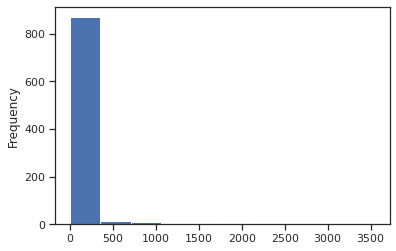

In [34]:
y_test_regression.plot.hist()

2. <u>Building a Classification target variable</u>

In [35]:
# We record the DAYS_NEXT_ADMIT, NEXT_ADMITTIME, DEATHTIME columns

y_train_classification = df_train[["DAYS_NEXT_ADMIT", "DEATHTIME"]].copy()
y_test_classification = df_test[["DAYS_NEXT_ADMIT", "DEATHTIME"]].copy()

print(y_train_classification.isnull().sum(),
      y_test_classification.isnull().sum(),
      sep="\n")

DAYS_NEXT_ADMIT     790
DEATHTIME          1842
dtype: int64
DAYS_NEXT_ADMIT    375
DEATHTIME          843
dtype: int64


In [36]:
# Based on our classification assumptions we construct a target 
# variable with the following values:

for table in [y_train_classification, y_test_classification]:
    # "DEAD" if DEATHTIME is not NaN
    # "READMISSION" if DAYS_NEXT_ADMIT are not NaN
    # "REMISSION" if neither DEATTIME or DAYS_NEXT_ADMIT are NaN
    table["OUTCOME"] = "READMISSION"
    table["OUTCOME"][table["DEATHTIME"].isnull()==False] = "DEAD"
    table["OUTCOME"][table["DAYS_NEXT_ADMIT"].isnull() &
                     table["DEATHTIME"].isnull()] = "REMISSION"
    # we drop columns as they are not useful anymore
    table.drop(["DAYS_NEXT_ADMIT"], axis = 1, inplace = True)
    table.drop(["DEATHTIME"], axis = 1, inplace = True)

In [37]:
# We check our target variables (with the example of the train target
# variables)

y_train_classification.value_counts()

OUTCOME    
READMISSION    1194
REMISSION       648
DEAD            158
dtype: int64

## 3. Modeling

<u>Approach for Regression:</u>

To evaluate our Linear Regression model, we will be using the Mean Squared Error and Coefficient of Determination $R^2$.

$${MSE} = \frac{1}{n}\overset{n}{\underset{i=1}{\sum}}(Y_i - \hat{Y}_i)^2$$

With $Y$ the vector of observed values of the variable being predicted, $\hat{Y}$ the predicted values.

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

with $SS_{tot}$, the total sum of squares (and $\bar{y} = \frac{1}{n}\overset{n}{\underset{i=1}{\sum}}Y_i$):

$$SS_{tot} = \overset{n}{\underset{i=1}{\sum}}(Y_i - \bar{Y})$$

And with $SS_{res}$, the sum of squares of residuals, i.e., $MSE$.

<u>Approach for classification:</u>

Our Classification modeling comparison will focus on two score metrics:

- **Accuracy score**

> The accuracy score represents the ability of a model to correctly predict the label of each data point in a set. Mathematically, it represents the ratio of sum of true positive and true negatives out of all the predictions

$${ACC} = \frac{TP + TN}{TP+FN+TN+FP}$$

With $TP$ the true positives, $FN$ the false negatives, $TN$ the true negatives, and $FP$ the false positives.

- **F1 score**

> The F1 score represents a function of the model's precision (proportion of positive identifications that are actually correct) and recall (proportion of actual positive identifications that were identified correctly) scores. 
>
> This is a useful measure of the model while trying to optimize either or both of precision or recall score of the model.

$${Precision} = \frac{TP}{FP+TP}$$

$${Recall} = \frac{TP}{FN + TP}$$

$${F1\, score} = 2\times\frac{{Precision}\times{Recall}}{{Precision}+{Recall}}$$

### 3.1 Regression

#### 3.1.1 Implementing Linear Regression

In [38]:
# Model declaration and training

lm_model = LinearRegression()
lm_model.fit(X_train, y_train_regression)

LinearRegression()

In [39]:
# Model prediction

lm_pred_train = lm_model.predict(X_train)
lm_pred_test = lm_model.predict(X_test)

In [40]:
# Scores

lm_score = regression_score(lm_pred_train, lm_pred_test, 
                            y_train_regression, y_test_regression)

--- Train Set Scores ---
Mean squared error: 66385.03
Coefficient of determination: 0.35

--- Test Set Scores ---
Mean squared error: 647052694647822090240.00
Coefficient of determination: -11607800974059848.00


We see that the simple linear model is unable to work on the test set (see more details in the observation section below).

#### 3.1.2 Implementing Ridge

**Ridge**: Linear least squares method with L2 regularization. The goal is to minimize the objective function:

$$||y - X_i||^2_2 + \alpha * ||i||^2_2$$

This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm.

In [41]:
# Model declaration and training

rd_model = Ridge()
rd_model.fit(X_train, y_train_regression)

Ridge()

In [42]:
# Model prediction

rd_pred_train = rd_model.predict(X_train)
rd_pred_test = rd_model.predict(X_test)

In [43]:
# Scores
rd_score = regression_score(rd_pred_train, rd_pred_test, 
                            y_train_regression, y_test_regression)

--- Train Set Scores ---
Mean squared error: 74198.83
Coefficient of determination: 0.28

--- Test Set Scores ---
Mean squared error: 78625.82
Coefficient of determination: -0.41


A negative R2 coefficient indicates that the model is unfit to work on the test set (see more details in the observation section below).

#### 3.1.3 Implementing Lasso

**Ridge**: Linear model trainer with L1 prior as a regularizer. The goal is to minimize the objective function:

$$\frac{1}{2 * {n_{samples}}} * ||y - X_i||^2_2 + \alpha * ||i||_1$$

The Lasso model is optimizing the same objective function as the Elastic Net with l1_ratio=1.0 (no L2 penalty).

In [44]:
# Model declaration and training

la_model = Lasso()
la_model.fit(X_train, y_train_regression)

Lasso()

In [45]:
# Model prediction

la_pred_train = la_model.predict(X_train)
la_pred_test = la_model.predict(X_test)

In [46]:
# Scores
rd_score = regression_score(la_pred_train, la_pred_test, 
                            y_train_regression, y_test_regression)

--- Train Set Scores ---
Mean squared error: 95564.34
Coefficient of determination: 0.07

--- Test Set Scores ---
Mean squared error: 58363.95
Coefficient of determination: -0.05


A negative R2 coefficient indicates that the model is unfit to work on the test set (see more details in the observation section below).

#### 3.1.4 Implementing ElasticSearch

**ElasticSearch**: Linear regression with combined L1 and L2 priors as regularizer. The goal is to minimize the objective function:

$$\frac{1}{2 * {n_{samples}}} * ||y - X_i||^2_2 + \alpha * {l1\, ratio} * ||i||_1
+ 0.5 * \alpha * (1 - {l1\, ratio}) * ||w||^2_2$$

In [47]:
# Model declaration and training

el_model = ElasticNet()
el_model.fit(X_train, y_train_regression)

ElasticNet()

In [48]:
# Model prediction

el_pred_train = el_model.predict(X_train)
el_pred_test = el_model.predict(X_test)

In [49]:
# Scores
el_score = regression_score(el_pred_train, el_pred_test, 
                            y_train_regression, y_test_regression)

--- Train Set Scores ---
Mean squared error: 101421.39
Coefficient of determination: 0.01

--- Test Set Scores ---
Mean squared error: 56424.79
Coefficient of determination: -0.01


A negative R2 coefficient indicates that the model is unfit to work on the test set (see more details in the observation section below).

#### 3.1.5 Observations

<span style="color:green">We see that **regression modeling has a hard time achieving proper results**. Our intuition as to why is that modeling a patient never returning to the hospital (i.e. no readmission) as a 0-value in the target variable Y likely influences this result. A 0-value might interfer with how regression works.</span>

<span style="color:green">As we noted prior in the data preprocessing part, representing the absence of readmission is the hard part of thinking about the MIMIC dataset. **It is  likely that regression is ill-suited for the dataset, as the dataset relates more to classification problems** (Indeed, the dataset implies implicit classes like "READMISSION", "REMISSION", and "DEATH"). It does not mean, however, that we should throw regression away wholesale.</span>

<u>Performing regression after classification</u>

In a more complex model, it would be interesting to see a regression implemented after a classification. Predicting readmission/re-hospitalization rates is interesting, but **once readmission is expected, predicting the expected time frame (day length) when the readmission will occur is of prime interest**.

### 3.2 Classification

#### 3.2.1 Logistic Regression

In [50]:
# Model declaration and training

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train_classification)

LogisticRegression()

In [51]:
# Model prediction

lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)

In [52]:
# Scores

lr_score = classification_score(lr_pred_train, lr_pred_test, 
                                y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 0.69
F1 score: 0.73

--- Test Set Scores ---
Accuracy: 0.64
F1 score: 0.69


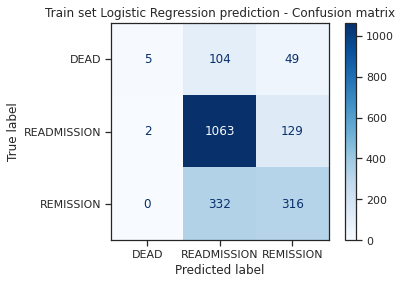

In [53]:
# Confusion Matrices

confusion(lr_model, X_train, y_train_classification, 
          "Train set Logistic Regression prediction - Confusion matrix")

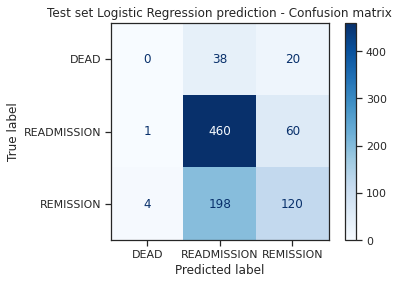

In [54]:
confusion(lr_model, X_test, y_test_classification, 
          "Test set Logistic Regression prediction - Confusion matrix")

We see that the classification model has a difficulty identifying DEATH datapoints. This might be due to dataset imbalance.

<u>Hyperparameter tuning via GridSearch:</u>

In [55]:
# Going further with GridSearch

parameters = {"penalty":("l1", "l2", "elasticnet", "none"),
              "solver":("newton-cg", "lbfgs", "liblinear", "sag", "saga"),
              "max_iter":(100, 300, 500, 1000, 2000)}

# Model declaration and training

lr_model = LogisticRegression()
lr_grid_search = GridSearchCV(lr_model, parameters)
lr_grid_search.fit(X_train, y_train_classification)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'max_iter': (100, 300, 500, 1000, 2000),
                         'penalty': ('l1', 'l2', 'elasticnet', 'none'),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')})

In [56]:
# Prints the best parameters

lr_grid_search.best_params_

{'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

In [57]:
# Model prediction

lr_grid_pred_train = lr_grid_search.predict(X_train)
lr_grid_pred_test = lr_grid_search.predict(X_test)

# Scores

lr_grid_score = classification_score(lr_grid_pred_train, lr_grid_pred_test, 
                                     y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 0.67
F1 score: 0.72

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.69


#### 3.2.2 KNN

In [58]:
# Model declaration and training

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train_classification)

KNeighborsClassifier()

In [59]:
# Model prediction

knn_pred_train = knn_model.predict(X_train)
knn_pred_test = knn_model.predict(X_test)

In [60]:
# Scores

knn_score = classification_score(knn_pred_train, knn_pred_test, 
                                 y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 0.70
F1 score: 0.72

--- Test Set Scores ---
Accuracy: 0.55
F1 score: 0.60


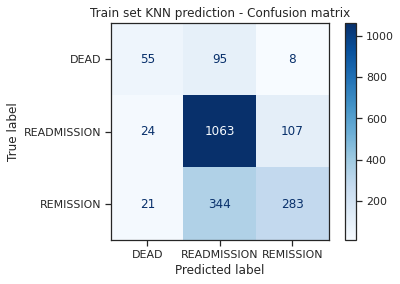

In [61]:
# Confusion Matrices

confusion(knn_model, X_train, y_train_classification, 
          "Train set KNN prediction - Confusion matrix")

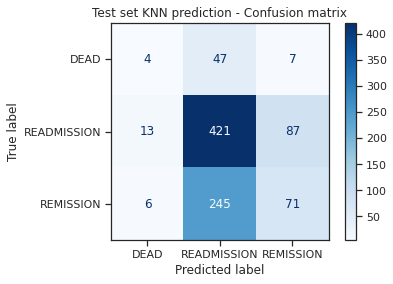

In [62]:
confusion(knn_model, X_test, y_test_classification, 
          "Test set KNN prediction - Confusion matrix")

We see that the classification model has a difficulty identifying DEATH datapoints. This might be due to dataset imbalance.

<u>Hyperparameter tuning via GridSearch:</u>

In [63]:
# Going further with GridSearch

parameters = {"weights":("uniform", "distance"),
              "algorithm":("auto", "ball_tree", "kd_tree", "brute"),
              "n_neighbors": list(range(5, 40))}

# Model declaration and training

knn_model = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn_model, parameters)
knn_grid_search.fit(X_train, y_train_classification)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                         26, 27, 28, 29, 30, 31, 32, 33, 34, ...],
                         'weights': ('uniform', 'distance')})

In [64]:
# Prints the best parameters

knn_grid_search.best_params_

{'algorithm': 'auto', 'n_neighbors': 25, 'weights': 'uniform'}

In [65]:
# Model prediction

knn_grid_pred_train = knn_grid_search.predict(X_train)
knn_grid_pred_test = knn_grid_search.predict(X_test)

# Scores

knn_grid_score = classification_score(knn_grid_pred_train, knn_grid_pred_test, 
                                      y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 0.62
F1 score: 0.70

--- Test Set Scores ---
Accuracy: 0.60
F1 score: 0.69


#### 3.2.3 Naive Bayes

In [66]:
# Model declaration and training

nb_model = GaussianNB()
nb_model.fit(X_train, y_train_classification)

GaussianNB()

In [67]:
# Model prediction

nb_pred_train = nb_model.predict(X_train)
nb_pred_test = nb_model.predict(X_test)

In [68]:
# Scores

nb_score = classification_score(nb_pred_train, nb_pred_test, 
                                y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 0.40
F1 score: 0.37

--- Test Set Scores ---
Accuracy: 0.24
F1 score: 0.22


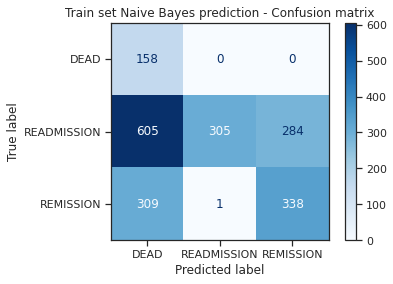

In [69]:
# Confusion Matrices

confusion(nb_model, X_train, y_train_classification, 
          "Train set Naive Bayes prediction - Confusion matrix")

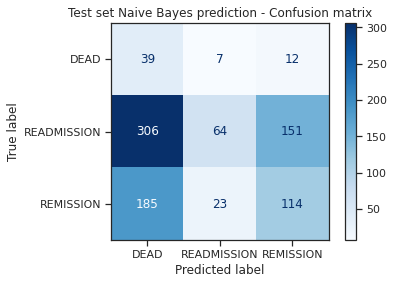

In [70]:
confusion(nb_model, X_test, y_test_classification, 
          "Test set Naive Bayes prediction - Confusion matrix")

Naive Bayes fares much poorer as a model compared to the ones we've seen so far, having a hard time predicting readmissions at all.

<u>Hyperparameter tuning via GridSearch:</u>

Naive Bayes, being naive, does not offer hyperparameters to play with beside ``sample_weight`` (i.e. weights applied to individual samples). As such, we do not perform GridSearch for Naive Bayes. 

#### 3.2.4 Random Forest

In [71]:
# Model declaration and training

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train_classification)

RandomForestClassifier()

In [72]:
# Model prediction

rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

In [73]:
# Scores
rf_score = classification_score(rf_pred_train, rf_pred_test, 
                                y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 1.00
F1 score: 1.00

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.67


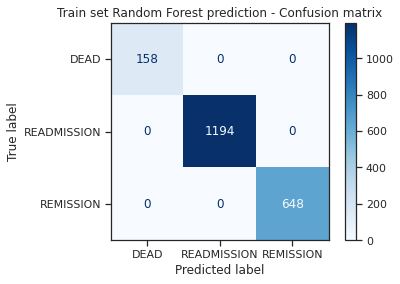

In [74]:
# Confusion Matrices

confusion(rf_model, X_train, y_train_classification, 
          "Train set Random Forest prediction - Confusion matrix")

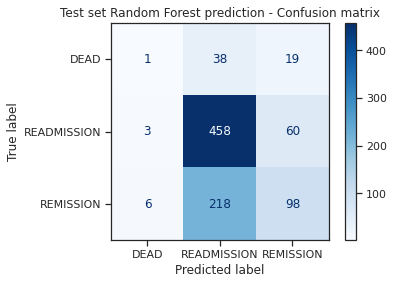

In [75]:
confusion(rf_model, X_test, y_test_classification, 
          "Test set Random Forest prediction - Confusion matrix")

We see that the classification model has a difficulty identifying DEATH datapoints. This might be due to dataset imbalance.

<u>Hyperparameter tuning via GridSearch:</u>

In [76]:
# Going further with GridSearch

parameters = {"criterion":("gini", "entropy"),
              "max_features":("auto", "sqrt", "log2"),
              "max_depth": list(range(5, 40))}

# Model declaration and training

rf_model = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf_model, parameters)
rf_grid_search.fit(X_train, y_train_classification)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                       26, 27, 28, 29, 30, 31, 32, 33, 34, ...],
                         'max_features': ('auto', 'sqrt', 'log2')})

In [77]:
# Prints the best parameters

rf_grid_search.best_params_

{'criterion': 'gini', 'max_depth': 37, 'max_features': 'auto'}

In [78]:
# Model prediction

rf_grid_pred_train = rf_grid_search.predict(X_train)
rf_grid_pred_test = rf_grid_search.predict(X_test)

# Scores

rf_grid_score = classification_score(rf_grid_pred_train, rf_grid_pred_test, 
                                     y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 0.88
F1 score: 0.89

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.70


#### 3.2.5 SVM

In [79]:
# Model declaration and training

svc_model = SVC()
svc_model.fit(X_train, y_train_classification)

SVC()

In [80]:
# Model prediction

svc_pred_train = svc_model.predict(X_train)
svc_pred_test = svc_model.predict(X_test)

In [81]:
# Scores
rf_score = classification_score(svc_pred_train, svc_pred_test, 
                                y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 0.60
F1 score: 0.75

--- Test Set Scores ---
Accuracy: 0.58
F1 score: 0.73


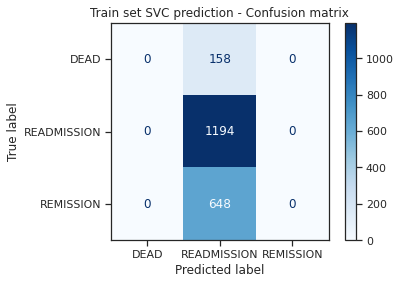

In [82]:
# Confusion Matrices

confusion(svc_model, X_train, y_train_classification, 
          "Train set SVC prediction - Confusion matrix")

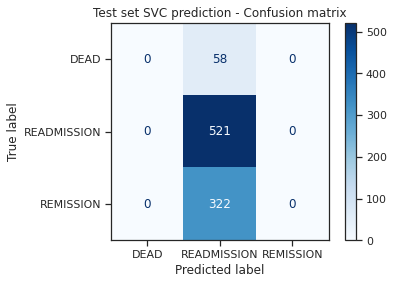

In [83]:
confusion(svc_model, X_test, y_test_classification, 
          "Test set SVC prediction - Confusion matrix")

We see that the classification model has a difficulty identifying DEATH datapoints. This might be due to dataset imbalance.

<u>Hyperparameter tuning via GridSearch:</u>

In [86]:
# Going further with GridSearch

parameters = {"kernel":("linear", "poly", "rbf"),
              "decision_function_shape":("ovo", "ovr"),
              "degree": list(range(3, 20))}

# Model declaration and training

svc_model = SVC()
svc_grid_search = GridSearchCV(svc_model, parameters)
svc_grid_search.fit(X_train, y_train_classification)

GridSearchCV(estimator=SVC(),
             param_grid={'decision_function_shape': ('ovo', 'ovr'),
                         'degree': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                    16, 17, 18, 19],
                         'kernel': ('linear', 'poly', 'rbf')})

In [87]:
# Prints the best parameters

svc_grid_search.best_params_

{'decision_function_shape': 'ovo', 'degree': 3, 'kernel': 'linear'}

In [88]:
# Model prediction

svc_grid_pred_train = svc_grid_search.predict(X_train)
svc_grid_pred_test = svc_grid_search.predict(X_test)

# Scores

svc_grid_score = classification_score(svc_grid_pred_train, svc_grid_pred_test, 
                                      y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 0.76
F1 score: 0.78

--- Test Set Scores ---
Accuracy: 0.64
F1 score: 0.67


#### 3.2.6 Summarizing results

<Figure size 1080x1080 with 0 Axes>

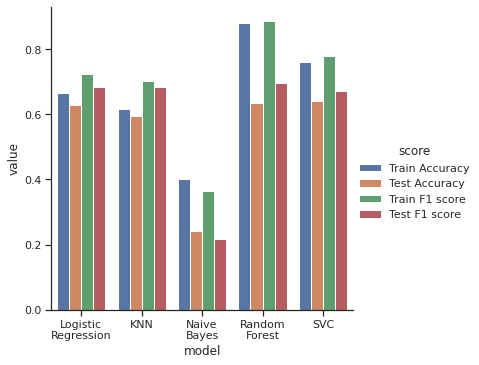

In [89]:
# We plot the results obtained from our best models across all 4 methods

results = {"Logistic\nRegression":lr_grid_score,
           "KNN":knn_grid_score,
           "Naive\nBayes":nb_score,
           "Random\nForest":rf_grid_score,
            "SVC":svc_grid_score}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<span style="color:green">Based on the results above, we find that the two best models are **logistic regression** and **random forest**. However, since that their F1 scores are very similar, we use the accuracy score to discriminate between the two models.</span>

<span style="color:green">**Consequently, we choose to select Random Forest as our best model**, yielding the following scores:</span>

- <span style="color:green">**Train set accuracy**: 0.88</span>
- <span style="color:green">**Test set accuracy**: 0.63</span>
- <span style="color:green">**Train set F1 score**: 0.89</span>
- <span style="color:green">**test set F1 score**: 0.70</span>

<span style="color:green">With the following parameters:</span>

- <span style="color:green">**Criterion**: gini</span> (measure the quality of a split: gini impurity)
- <span style="color:green">**max_depth**: 37</span> (maximum tree depth)
- <span style="color:green">**max_features**: auto</span> (number of features to consider when looking for the best split. If “auto”, then it is similar to "sqrt" with $max\_features=\sqrt{n_{features}}$)

<u>Notes:</u>

The **gini criterion** refer to the probability of classifying a datapoint incorrectly in a dataset as part of building the random forest classifier.

For $C$ total classes (here 3: "READMISSION", "REMISSION", and "DEATH"), and $p(i)$ the probability of picking a datapoint with class $i$, the Gini Impurity is calculated as:

$$G = \underset{i=1}{\overset{C}{\sum}}p(i)*(1-p(i))$$

We want to minimize this gini impurity metrics (a gini impurity of 0 implies a perfect split of the dataset). 

Meanwhile, **entropy** is a measure of the disorder or unpredictability in a system. Given a two-class classification $C$, and a sample set $S$, the class distribution at any node can be written as $(p_0, p_1)$ where $p_1 = 1-p_0$ and the entropy of S is the sum of the information:

$$E(S) = -p_0 \times log_2(p_0) - p_1 \times log_2(p_1)$$

## 4. Exploring our best model
    
### 4.1 Removing ETHNICITY from the dataset

We come back to our note with regards to the dataset (made in Part 2: Data Preprocessing).

> consequently, <span style="color:red">we will need to see if ethnicity has a strong effect on our end result, and, if possible, whether we can do without it</span>.

To do so, we go back to our training and testing dataset and remove the one-hot encoding columns that were built out of the ETHNICITY column present in our original dataset.

The goal here is to:

- Train a Random Forest Classifier with the same parameters but without using ethnic data
- Compare the results
- Draw preliminary interpretations of the results

In [93]:
# Removing the ethnic data from our train and test datasets

X_train_wo_eth = X_train[X_train.columns.drop(list(X_train.filter(regex='ETHNICITY')))]
X_test_wo_eth = X_test[X_test.columns.drop(list(X_test.filter(regex='ETHNICITY')))]

In [94]:
# Assigning the Random Forest best parameters to variables

criterion = "gini"
max_depth = 37
max_features = "auto"

In [95]:
# Model declaration and training

rf_model_wo_eth = RandomForestClassifier(criterion=criterion, 
                                         max_depth=max_depth, 
                                         max_features=max_features)

rf_model_wo_eth.fit(X_train_wo_eth, y_train_classification)

RandomForestClassifier(max_depth=37)

In [96]:
# Model prediction

rf_pred_train_wo_eth = rf_model_wo_eth.predict(X_train_wo_eth)
rf_pred_test_wo_eth = rf_model_wo_eth.predict(X_test_wo_eth)

In [97]:
# Scores

rf_score_wo_eth = classification_score(rf_pred_train_wo_eth, rf_pred_test_wo_eth, 
                                       y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 0.83
F1 score: 0.85

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.69


<Figure size 1080x1080 with 0 Axes>

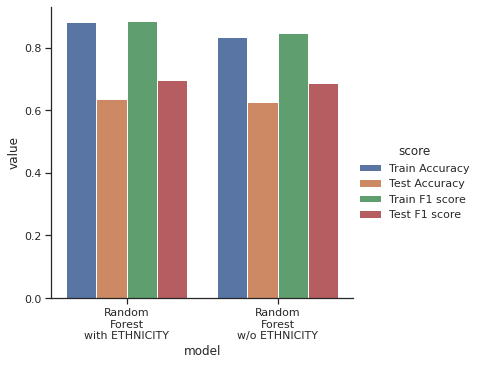

In [98]:
# We plot the results obtained from our best models across all 
# 4 methods

results = {"Random\nForest\nwith ETHNICITY":rf_grid_score,
           "Random\nForest\nw/o ETHNICITY":rf_score_wo_eth}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<u>Observations:</u>

We see that removing ETHNICITY from the dataset has a very minor if non-existent impact on the obtained scores:

- training accuracy and F1 scores went down by 5 and 4 basis points respectively
- testing accuracy and F1 scores went down by 0 and 1 basis points respectively

Consequently, we can raise doubts on the usefulness of collecting/using this specific data as part of this prediction modeling. There is no question that relying on this variable can be risky and would raise ethical concerns as, beyond the realm of rehospitalization prediction, the use of ethnic data presents a high risk of misuse (e.g. AI ethicists fear the return of physiognomy in today's discourse, for instance with the power of facial recognition and ethnic profiling. [In 2016, a research paper attracted heavy criticism by attempting to infer criminality from facial features](https://confilegal.com/wp-content/uploads/2016/11/ESTUDIO-UNIVERSIDAD-DE-JIAO-TONG-SHANGHAI.pdf)).

### 4.2 Performing PCA on our Bag of Words Representation

We are looking to reduce the size of our training and testing sets. As such, we might want to explore Principal Component Analysis (PCA) to do that by targeting our Bag of Words representation of the DIAGNOSIS column from the original data.

We will apply PCA to the dataset and see how many dimensions we need in the embedded space to obtain a 99% explained variance.

In [100]:
# Retrieving the bag of word representation from our pre-processed 
# dataset

X_train_bow = X_train[cv.get_feature_names()]
X_test_bow = X_test[cv.get_feature_names()]

In [101]:
# Fitting a PCA model to find the number of components that has a 99%
# explained variance

number_of_components = 1

while True:
    pca_model = PCA(n_components=number_of_components, 
                    svd_solver='full')
    pca_model.fit(X_train_bow)
    if sum(pca_model.explained_variance_ratio_)>=0.99:
        X_train_pca = pca_model.transform(X_train_bow)
        X_test_pca = pca_model.transform(X_test_bow)
        print("\n99% variance explained mark reached at:\n",
              f"{number_of_components} components")
        break
    number_of_components += 1


99% variance explained mark reached at:
 525 components


In [102]:
# Replacing the bag of word representation in the train and test
# datasets with the PCA

X_train_pca = pd.concat([X_train.drop(cv.get_feature_names(), axis=1), 
                       pd.DataFrame(X_train_pca)], axis = 1)
X_test_pca = pd.concat([X_test.drop(cv.get_feature_names(), axis=1), 
                       pd.DataFrame(X_test_pca)], axis = 1)

In [103]:
# Model declaration and training

rf_model_PCA = RandomForestClassifier(criterion=criterion, 
                                      max_depth=max_depth,
                                      max_features=max_features)

rf_model_PCA.fit(X_train_pca, y_train_classification)

RandomForestClassifier(max_depth=37)

In [104]:
# Model prediction

rf_pred_train_PCA = rf_model_PCA.predict(X_train_pca)
rf_pred_test_PCA = rf_model_PCA.predict(X_test_pca)

In [105]:
# Scores

rf_score_PCA = classification_score(rf_pred_train_PCA, rf_pred_test_PCA, 
                                    y_train_classification, y_test_classification)

--- Train Set Scores ---
Accuracy: 1.00
F1 score: 1.00

--- Test Set Scores ---
Accuracy: 0.60
F1 score: 0.64


<Figure size 1080x1080 with 0 Axes>

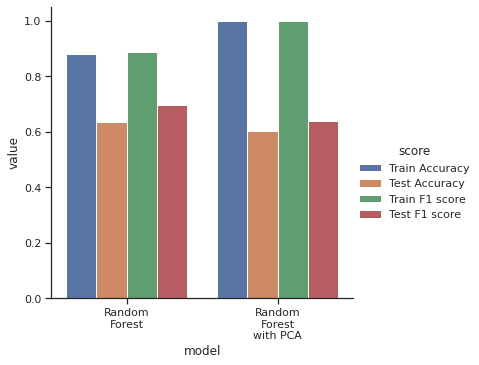

In [106]:
# We plot the results obtained from our best models across all 
# 4 methods

results = {"Random\nForest":rf_grid_score,
           "Random\nForest\nwith PCA":rf_score_PCA}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<u>Observations:</u>

We see that, thanks to PCA, we can reduce our dataset size by reducing the dimension of the Bag of Words representation (over the DIAGNOSIS column of the original dataset). Using a PCA result that explains 99% of the variance in the bag of word, we see that:

- we can increase the accuracy and F1 scores over the training set to 1

- However, we see that performing CPA leads to a reduction in the test accuracy and F1 score by a factor of 3 and 6 basis points respectively.

### 4.3 Binary Classification

Up until now, we have looked at performing a 3-class classification problem. I.e. we wanted to predict either READMISSION, DEATH or REMISSION. If we want to **purely be interested in READMISSION**, we can **merge DEATH and REMISSION** in our target dataset.

In [107]:
# We replace DEATH and REMISSION instances with NEVER_REHOSPITALIZED, creating a 
# binary classification problem

y_train_binary = y_train_classification.copy()
y_test_binary = y_test_classification.copy()

y_train_binary[y_train_binary=="DEAD"]="NEVER_REHOSPITALIZED"
y_train_binary[y_train_binary=="REMISSION"]="NEVER_REHOSPITALIZED"
y_test_binary[y_test_binary=="DEAD"]="NEVER_REHOSPITALIZED"
y_test_binary[y_test_binary=="REMISSION"]="NEVER_REHOSPITALIZED"

In [108]:
# Going further with GridSearch

parameters = {"criterion":("gini", "entropy"),
              "max_features":("auto", "sqrt", "log2"),
              "max_depth": list(range(5, 50))}

# Model declaration and training

rf_model = RandomForestClassifier()
rf_model_binary = GridSearchCV(rf_model, parameters)
rf_model_binary.fit(X_train, y_train_binary)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                       16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                       26, 27, 28, 29, 30, 31, 32, 33, 34, ...],
                         'max_features': ('auto', 'sqrt', 'log2')})

In [109]:
# Prints the best parameters

rf_model_binary.best_params_

{'criterion': 'gini', 'max_depth': 26, 'max_features': 'auto'}

In [110]:
# Model prediction

rf_pred_train_bin = rf_model_binary.predict(X_train)
rf_pred_test_bin = rf_model_binary.predict(X_test)

# Scores

rf_score_bin = classification_score(rf_pred_train_bin, rf_pred_test_bin, 
                                    y_train_binary, y_test_binary)

--- Train Set Scores ---
Accuracy: 0.85
F1 score: 0.86

--- Test Set Scores ---
Accuracy: 0.67
F1 score: 0.71


<Figure size 1080x1080 with 0 Axes>

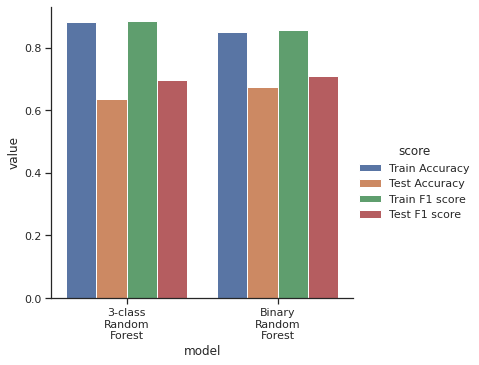

In [111]:
# We plot the results obtained from our best models across all 4 methods

results = {"3-class\nRandom\nForest":rf_grid_score,
           "Binary\nRandom\nForest":rf_score_bin}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<u>Observations:</u>

We see that by going for a binary classification, using grid search, we don't find a much better result in terms of accuracy or F1 score (we have a lower accuracy overall, but traded off with a marginally better F1 score). As such, we can infer that **in the case of binary classification, a random forest classifier might not be the best model to go for**.

In all likelihood, a logistic regression model might fare better.

### 4.4 Overall Parameter Impact Overview

Given that we looked at a lot of different models via grid search, it would be interesting to look into the impact each parameter has on the model performance.

In [112]:
# Recall the parameters used for the random forest grid search

criterions = ("gini", "entropy")

max_features = ("auto", "sqrt", "log2")

max_depths = list(range(5, 60, 5))

In [113]:
# Training a random forest while varying the criterion

criterion_results = []

for criterion in criterions:
    model = RandomForestClassifier(criterion=criterion,
                                   max_depth=37,
                                   max_features="sqrt")
    model.fit(X_train, y_train_classification)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"\nModeling with criterion: {criterion}")
    score = classification_score(pred_train, pred_test,
                                 y_train_classification, y_test_classification)
    criterion_results.append(score)


Modeling with criterion: gini
--- Train Set Scores ---
Accuracy: 0.89
F1 score: 0.89

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.69

Modeling with criterion: entropy
--- Train Set Scores ---
Accuracy: 0.90
F1 score: 0.90

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.69


<Figure size 1080x1080 with 0 Axes>

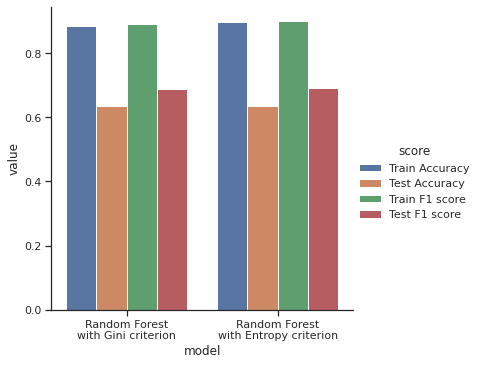

In [114]:
# Plotting the change due to criterion

results = {"Random Forest\nwith Gini criterion":criterion_results[0],
           "Random Forest\nwith Entropy criterion":criterion_results[1]}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<u>Observations:</u>

We see that Gini and Entropy as criterion lead to very similar results with Entropy barely pulling ahead.

<hr>

In [115]:
# Training a random forest while varying the criterion

max_depth_results = []

for max_depth in max_depths:
    model = RandomForestClassifier(criterion="gini",
                                   max_depth=max_depth,
                                   max_features="sqrt")
    model.fit(X_train, y_train_classification)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"\nModeling with max depth: {max_depth}")
    score = classification_score(pred_train, pred_test,
                                 y_train_classification, y_test_classification)
    max_depth_results.append(score)


Modeling with max depth: 5
--- Train Set Scores ---
Accuracy: 0.61
F1 score: 0.75

--- Test Set Scores ---
Accuracy: 0.58
F1 score: 0.73

Modeling with max depth: 10
--- Train Set Scores ---
Accuracy: 0.66
F1 score: 0.75

--- Test Set Scores ---
Accuracy: 0.60
F1 score: 0.71

Modeling with max depth: 15
--- Train Set Scores ---
Accuracy: 0.71
F1 score: 0.76

--- Test Set Scores ---
Accuracy: 0.61
F1 score: 0.71

Modeling with max depth: 20
--- Train Set Scores ---
Accuracy: 0.77
F1 score: 0.80

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.70

Modeling with max depth: 25
--- Train Set Scores ---
Accuracy: 0.80
F1 score: 0.82

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.70

Modeling with max depth: 30
--- Train Set Scores ---
Accuracy: 0.83
F1 score: 0.85

--- Test Set Scores ---
Accuracy: 0.63
F1 score: 0.69

Modeling with max depth: 35
--- Train Set Scores ---
Accuracy: 0.86
F1 score: 0.87

--- Test Set Scores ---
Accuracy: 0.65
F1 score: 0.71

Modeling with max depth: 40

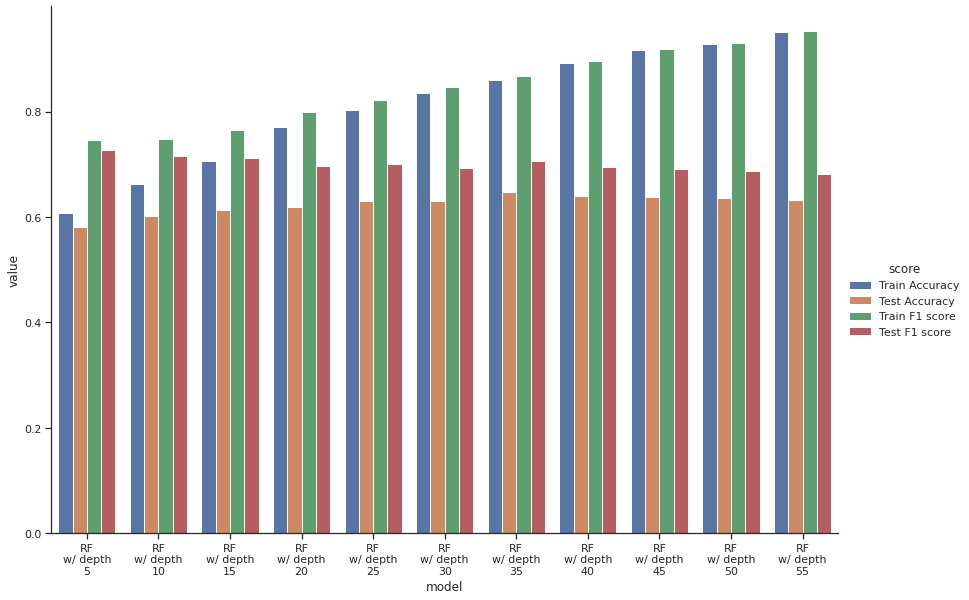

In [116]:
# Plotting the change due to Max Depth

results = {f"RF\nw/ depth\n{d}":max_depth_results[idx] for 
           idx, d in enumerate(max_depths)}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True)

sns.catplot(x="model", y="value", hue="score", kind="bar", data=results,
           height=8.27, aspect=11.7/8.27)

<u>Observations:</u>

We see that Accuracy consistently increases with the depth. Meanwhile the F1 score plateaus or even decreaseds after a while

<hr>

In [117]:
# Training a random forest while varying the criterion

max_features_results = []

for feature in max_features:
    model = RandomForestClassifier(criterion="gini",
                                   max_depth=37,
                                   max_features=feature)
    model.fit(X_train, y_train_classification)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"\nModeling with max features: {feature}:")
    score = classification_score(pred_train, pred_test,
                                 y_train_classification, y_test_classification)
    max_features_results.append(score)


Modeling with max features: auto:
--- Train Set Scores ---
Accuracy: 0.88
F1 score: 0.89

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.68

Modeling with max features: sqrt:
--- Train Set Scores ---
Accuracy: 0.87
F1 score: 0.88

--- Test Set Scores ---
Accuracy: 0.64
F1 score: 0.70

Modeling with max features: log2:
--- Train Set Scores ---
Accuracy: 0.79
F1 score: 0.82

--- Test Set Scores ---
Accuracy: 0.62
F1 score: 0.71


<Figure size 1080x1080 with 0 Axes>

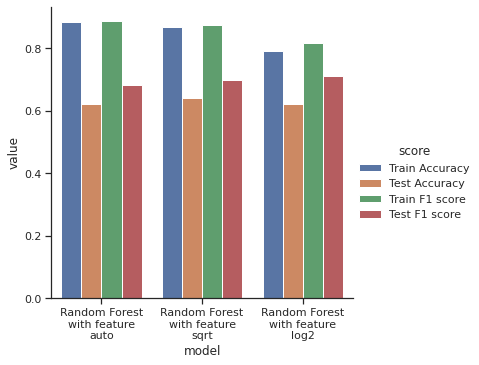

In [118]:
# Plotting the change due to criterion

results = {f"Random Forest\nwith feature\n{f}":max_features_results[idx] for 
           idx, f in enumerate(max_features)}

results = pd.DataFrame.from_dict(results).melt()

scores = cycle(["Train Accuracy","Test Accuracy","Train F1 score","Test F1 score"])
results['score'] = [next(scores) for _ in range(len(results))]
results.rename(columns = {'variable':'model'}, inplace=True) 

plt.figure(figsize=(15,15))
plot = sns.catplot(x="model", y="value", hue="score", kind="bar", data=results)

<u>Observations:</u>

We see that Auto and Sqrt as features lead to very similar results, barely pulling ahead of log2.

<hr>

<u>Final outlook on parameters' impact:</u>

Based on our observations, we see that:

- Gini is marginally better than Entropy as a criterion
- Accuracy seems proportional to the max depth of the model, however we see that past a certain point, the F1 score starts to decrease. 
- Sqrt and Auto are marginally better than log2 as a feature

This confirms the parameter choices obtained via grid search for our Random Forest model.

## 5. Conclusion

### 5.1 Variable and Model Choice

After some data pre-processing, we focus our modeling effort on the following variables:

| Variable | Note on preprocessing | 
| :--- | :--- |
| Age | Float variable constructed out of DOB and ADMITTIME |
| GENDER | One-Hot encoded | 
| MARITAL_STATUS | One-Hot encoded | 
| ETHNICITY | One-Hot encoded | 
| INSURANCE | One-Hot encoded | 
| ADMISSION_TYPE | One-Hot encoded | 
| Length of stay | Float variable constructed out of DISCTIME and ADMITTIME |
| DIAGNOSIS | A bag of words reprensentation created via CountVectorizer |

With regards to our classification effort, we have seen five different models. **Each model yielded the following best scores after thorough use of the GridSearch function** (provided by the scikit-learn library):

| Model | Train Accuracy | Test Accuracy | Train F1 Score | Test F1 Score | Our Final Choice |
| :--- | :--- | :--- | :--- | :--- | :---: |
| Logistic Regression | 0.67 | 0.63 | 0.72 | 0.69 | <span style="color:red">**$\times$**</span> |
| KNN | 0.62 | 0.60 | 0.70 | 0.69 | <span style="color:red">**$\times$**</span> |
| Naive Bayes | 0.40 | 0.24 | 0.37 | 0.22 | <span style="color:red">**$\times$**</span> |
| Random Forest | <span style="color:green">**0.88**</span> | 0.63 | <span style="color:green">**0.89**</span> | <span style="color:green">**0.70**</span> | <span style="color:green">**$\star$**</span> |
| Support Vector Machine for classification (SVC) | 0.76 | <span style="color:green">**0.64**</span> | 0.78 | 0.67 | <span style="color:red">**$\times$**</span> |

### 5.2 Best Model Parameters

We chose to continue forward with the **Random Forest Classifier** model, which results were maximized with the following parameters:

| Parameter | ArgMax for Model | Note |
| :--- | :---: | :--- |
| criterion | <span style="color:green">**gini**</span> | Measure of impurity of the prediction, chosen over '*entropy*' |
| max_feature | <span style="color:green">**auto**</span> | Similar to '*sqrt*' with ${max\_f}=\sqrt{n_{features}}$, it was chosen over the '*log2*' feature |
| max_depth  | <span style="color:green">**37**</span> | Maximum depth of the tree classifier |


### 5.3 Looking for ways to improve the predictions

We have looked into how to increase the performance of our best model, and have reached the following observations:


1. A **limitation** with regards to training the model **relates to how we represent our data**. It is possible, and rather likely, that we can achieve a better representation/embedding of our variables (such as with our bag of words embedding of the DIAGNOSIS collumn). 


2. **Some variables we have included might be removed**. It can be either for ethical reason (such as with the ETHNICITY variable) or for variance reason. Indeed, it is very likely that some included variables only have a limited, if not null, effect on the end prediction (e.g. removing the ETHNICITY variable from the dataset barely impacted end results). 


3. With regards to our selected model (a random forest classifier), we saw that **reducing the number of classes in our dataset from 3 to 2 barely changed the end predictive power**. As such, we might infer that **we have a limit in performance not set by hyperparameter choice, but by our choice of model**.


### 5.4 Further explorations?

Based on our observations above, we see that we might have end up with a limitation set both by our dataset representation but also by our model choice. As such, if further explorations were to be performed, we could focus on the following:

1. **Provide a new embedding/representation for the data** (for instance by including the variable TEXT after a thorough cleaning of the content due to data leakage risk). 


2. **Use more complex models** such as neural networks or deep learning in general (for instance a binary classifier using a dense and deep series of fully connected neural network layers). 